<a href="https://colab.research.google.com/github/lovelyoyrmia/Foedtra/blob/main/notebook/foedtra_modelv1_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Foedtra Transfer Learning Model V.1

Mounting google drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import json
import tempfile
import requests

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
  
# deep learning libraries
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, BatchNormalization, GlobalAveragePooling2D, Dense, Dropout
from keras.preprocessing import image

Load data

In [ ]:
root_path = '/content/drive/MyDrive/Capstone Project - Foedtra'
labels = os.path.join(root_path, 'dataframe', 'train_images.xlsx')
sample = os.path.join(root_path, 'dataframe', 'test_images.xlsx')

train_path = os.path.join(root_path, 'dataset', 'train')
test_path = os.path.join(root_path, 'dataset','test')

#### Processing dataframe

In [ ]:
def rename_path_images(name, labels, dirs):
  return os.path.join(os.path.join('/content/drive/MyDrive/Capstone Project - Foedtra/dataset', dirs, labels), name)

In [ ]:
train_df = pd.read_excel(labels)
test_df = pd.read_excel(sample)
dev_df = pd.read_excel(os.path.join(root_path, 'dataframe','dev_images.xlsx'))

In [ ]:
train_df['Filepath'] = train_df.apply(lambda x: rename_path_images(x['Filepath'], x['Label'], 'train'), axis=1)
test_df['Filepath'] = test_df.apply(lambda x: rename_path_images(x['Filepath'], x['Label'], 'test'), axis=1)

In [ ]:
print('Train has {} classes'.format(len(list(train_df['Label'].unique()))))
print('Test has {} classes'.format(len(list(test_df['Label'].unique()))))

Train has 34 classes
Test has 34 classes


### Create Generator

In [ ]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=False,
    shear_range=0.3,
    zoom_range=0.3,
    validation_split=0.2,
)

test_gen = ImageDataGenerator(
    rescale=1./255
)

### Image augmentation

In [ ]:
train_images = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_gen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
)

Found 920 validated image filenames belonging to 34 classes.
Found 230 validated image filenames belonging to 34 classes.
Found 331 validated image filenames belonging to 34 classes.


Show Image generator

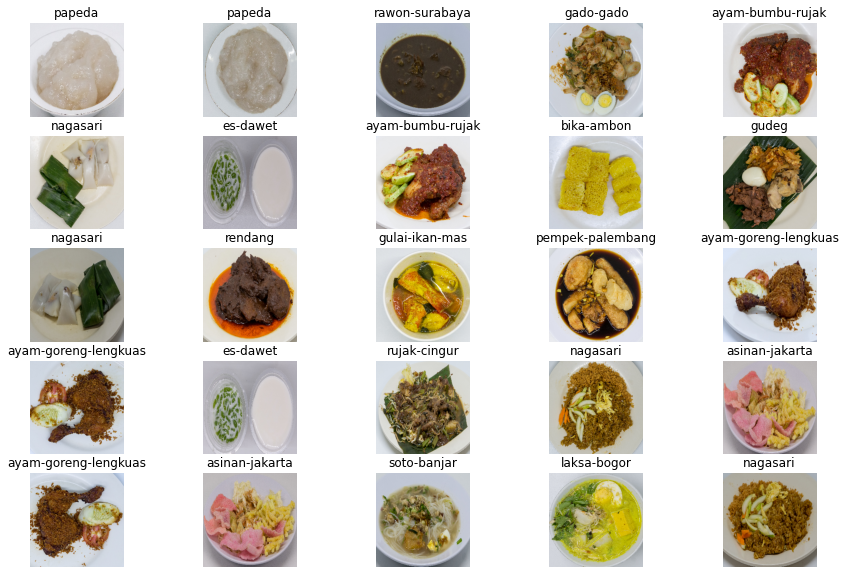

In [ ]:
class_labels = train_images.class_indices
class_names = list(class_labels.keys())
  
def plot_images(img,labels):
    plt.figure(figsize=[15,10])
    for i in range(25):
      plt.subplot(5,5,i+1)
      plt.imshow(img[i])
      plt.title(class_names[np.argmax(labels[i])])
      plt.axis('off')
    plt.show()

x, y = next(test_images)
plot_images(x,y)

## Modeling

Inception ResNet v2 architecture inspired by [this article](https://paperswithcode.com/method/inception-resnet-v2)

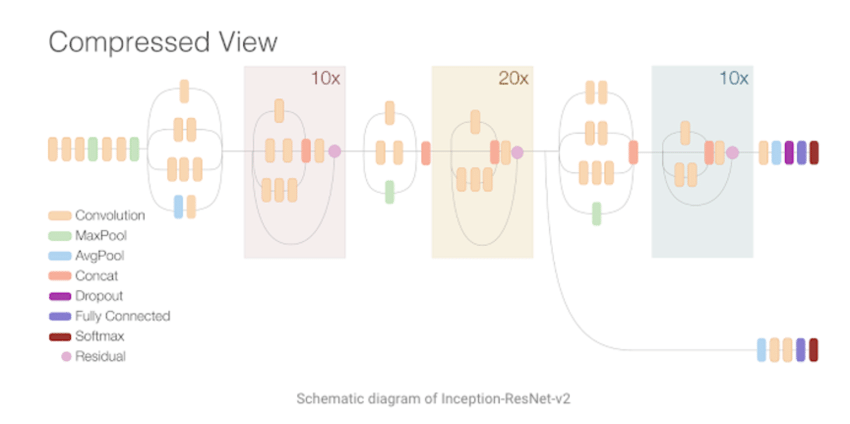

In [ ]:
pretrained_model = tf.keras.applications.InceptionResNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
)

pretrained_model.trainable = False

model = Sequential([
      pretrained_model,
      BatchNormalization(renorm=True),
      GlobalAveragePooling2D(), 
      Dense(512, activation='relu'), # 512 Neuron
      Dense(256, activation='relu'), # 256 Neuron
      Dropout(0.5), # Drop some neuron
      Dense(128, activation='relu'), # 128 Neuron
      Dense(34, activation='softmax') # 34 Classes
])

219070464/219055592 [==============================] - 2s 0us/step


Callback Class

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('accuracy') > 0.999:
            print("\nReached 99.9% accuracy so cancelling training!")
            self.model.stop_training = True

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                           
                                                                 
 batch_normalization_203 (Ba  (None, 5, 5, 1536)       10752     
 tchNormalization)                                               
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               786944    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                        

In [ ]:
batch_size=32
STEP_SIZE_TRAIN = train_images.n//train_images.batch_size
STEP_SIZE_VALID = val_images.n//val_images.batch_size
callbacks = myCallback()

# fit model
history = model.fit(train_images,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=val_images,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=25,
                    callbacks=[callbacks])

Epoch 1/25
28/28 [==============================] - 557s 19s/step - loss: 2.7465 - accuracy: 0.2613 - val_loss: 1.2730 - val_accuracy: 0.7321
Epoch 2/25
28/28 [==============================] - 350s 12s/step - loss: 0.9561 - accuracy: 0.7331 - val_loss: 0.2879 - val_accuracy: 0.9330
Epoch 3/25
28/28 [==============================] - 346s 12s/step - loss: 0.3395 - accuracy: 0.9009 - val_loss: 0.0455 - val_accuracy: 1.0000
Epoch 4/25
28/28 [==============================] - 355s 13s/step - loss: 0.1299 - accuracy: 0.9640 - val_loss: 0.0256 - val_accuracy: 1.0000
Epoch 5/25
28/28 [==============================] - 352s 13s/step - loss: 0.0721 - accuracy: 0.9821 - val_loss: 0.0549 - val_accuracy: 0.9911
Epoch 6/25
28/28 [==============================] - 355s 13s/step - loss: 0.0975 - accuracy: 0.9741 - val_loss: 0.0149 - val_accuracy: 0.9911
Epoch 7/25
28/28 [==============================] - 358s 13s/step - loss: 0.0524 - accuracy: 0.9865 - val_loss: 0.0087 - val_accuracy: 1.0000
Epoch 

## Evalute and Predict the Model

Text(0.5, 1.0, '\nTraining and Validation Accuracy. \nTrain Accuracy: 0.9797297120094299\nValidation Accuracy: 1.0')

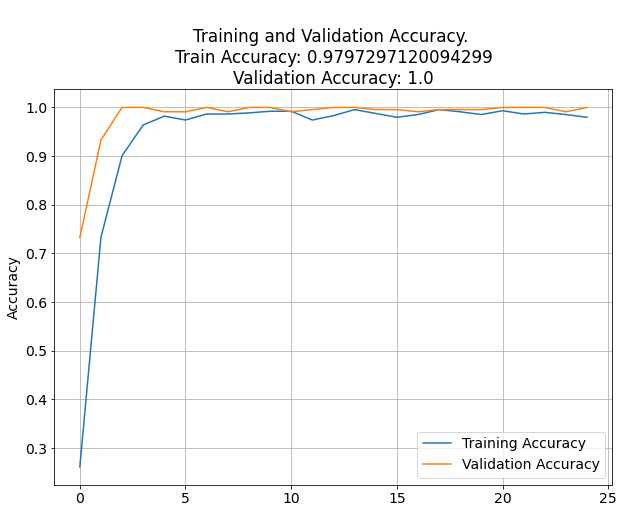

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
  
  
# Result Accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')
plt.show()

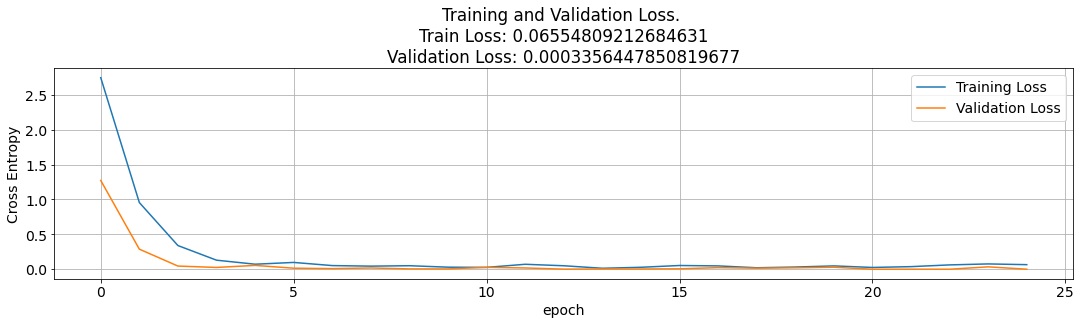

In [ ]:
# Result Loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

In [ ]:
accuracy_score = model.evaluate(val_images)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100)) 
  
print("Loss: ",accuracy_score[0])

8/8 [==============================] - 73s 8s/step - loss: 0.0362 - accuracy: 0.9957
[0.036200325936079025, 0.9956521987915039]
Accuracy: 99.5652%
Loss:  0.036200325936079025


## Predict model to dataframe

In [ ]:
def predict_model_from_dir(class_names):
  predictions = []
    
  for image in test_df['Filepath']:
      img = tf.keras.preprocessing.image.load_img(image)
      img = tf.keras.preprocessing.image.img_to_array(img)
      img = tf.keras.preprocessing.image.smart_resize(img, (224, 224))
      img = tf.reshape(img, (-1, 224, 224, 3))
      prediction = model.predict(img/255)
      prediction = np.argmax(prediction)
      prediction = class_names[prediction]
      predictions.append(prediction)

  return predictions

predictions = predict_model_from_dir()
my_submission = pd.DataFrame({'image_id': test_df['Filepath'], 'label':  predictions})
my_submission.to_excel('submission.xlsx', index=False, header=True)

In [ ]:
predicted_model = pd.read_excel('submission.xlsx', class_names)

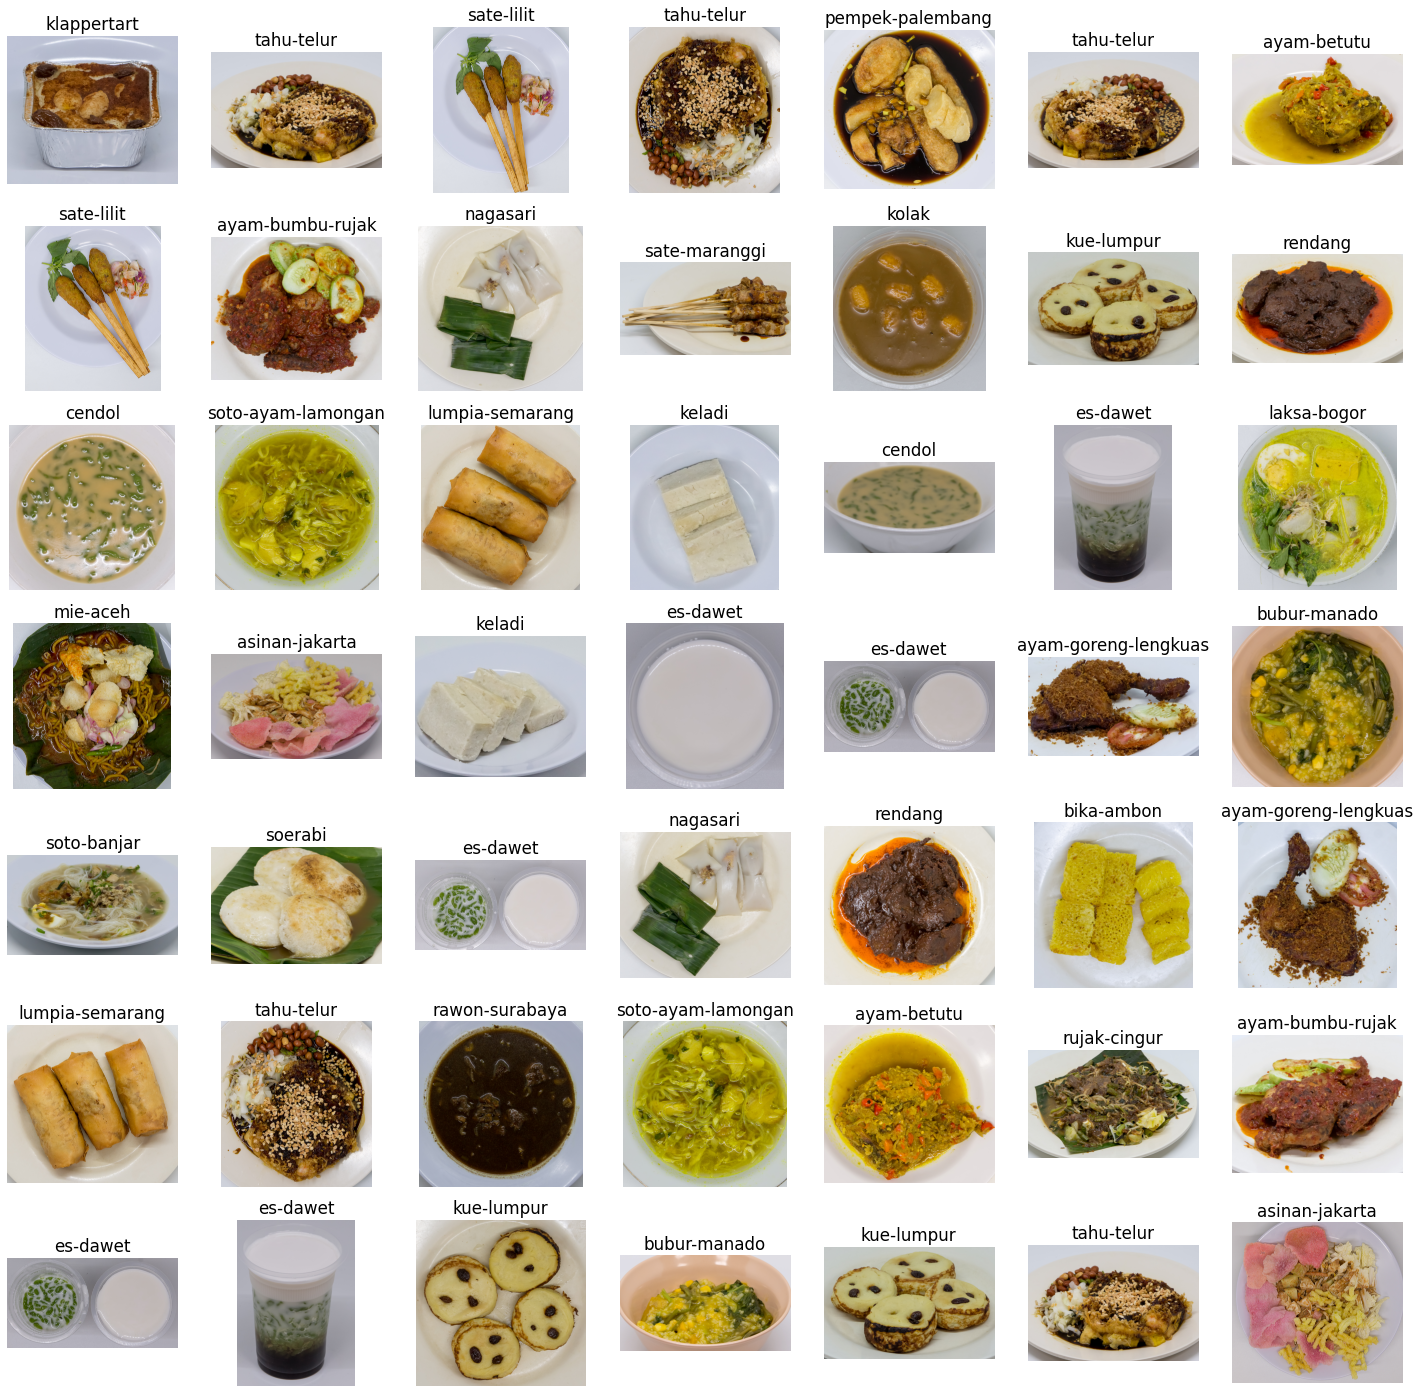

In [ ]:
plt.figure(figsize=[25,25])
for i in range(49):
  plt.subplot(7,7,i+1)
  image_test = plt.imread(predicted_model['image_id'][i])
  plt.imshow(image_test)
  plt.title(predicted_model['label'][i])
  plt.axis('off')
plt.show()

In [ ]:
def predict_image(path_image):
  img = tf.keras.preprocessing.image.load_img(path_image)
  img = tf.keras.preprocessing.image.img_to_array(img)
  img = tf.keras.preprocessing.image.smart_resize(img, (224, 224))
  img = tf.reshape(img, (-1, 224, 224, 3))
  prediction = model.predict(img/255)
  prediction = np.argmax(prediction)
  prediction = class_names[prediction]
  plt.title(prediction)
  img = plt.imread(path_image)
  plt.imshow(img)
  plt.show()

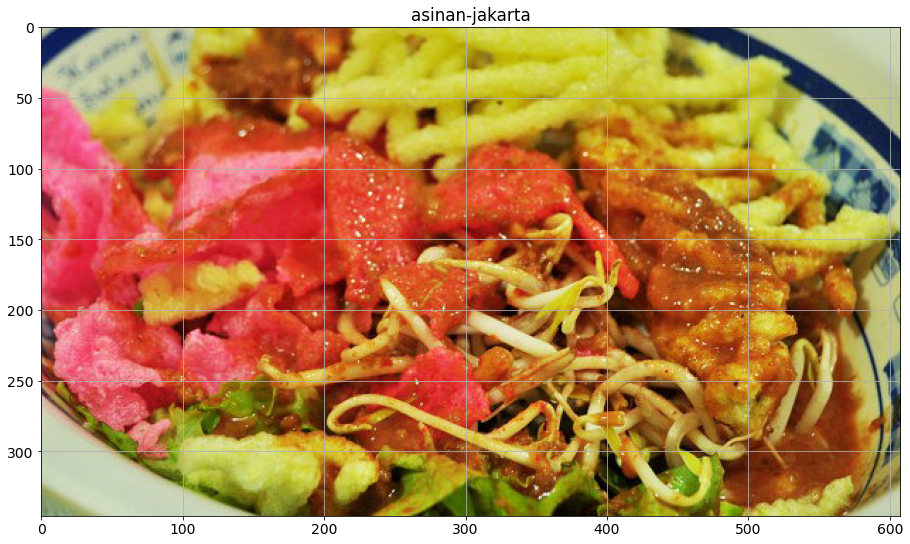

In [ ]:
predict_image('/content/anisanjakarta.jpeg')

### Visualisation predicted model

In [ ]:
predictions = np.argmax(model.predict(test_images), axis=1)
cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions)

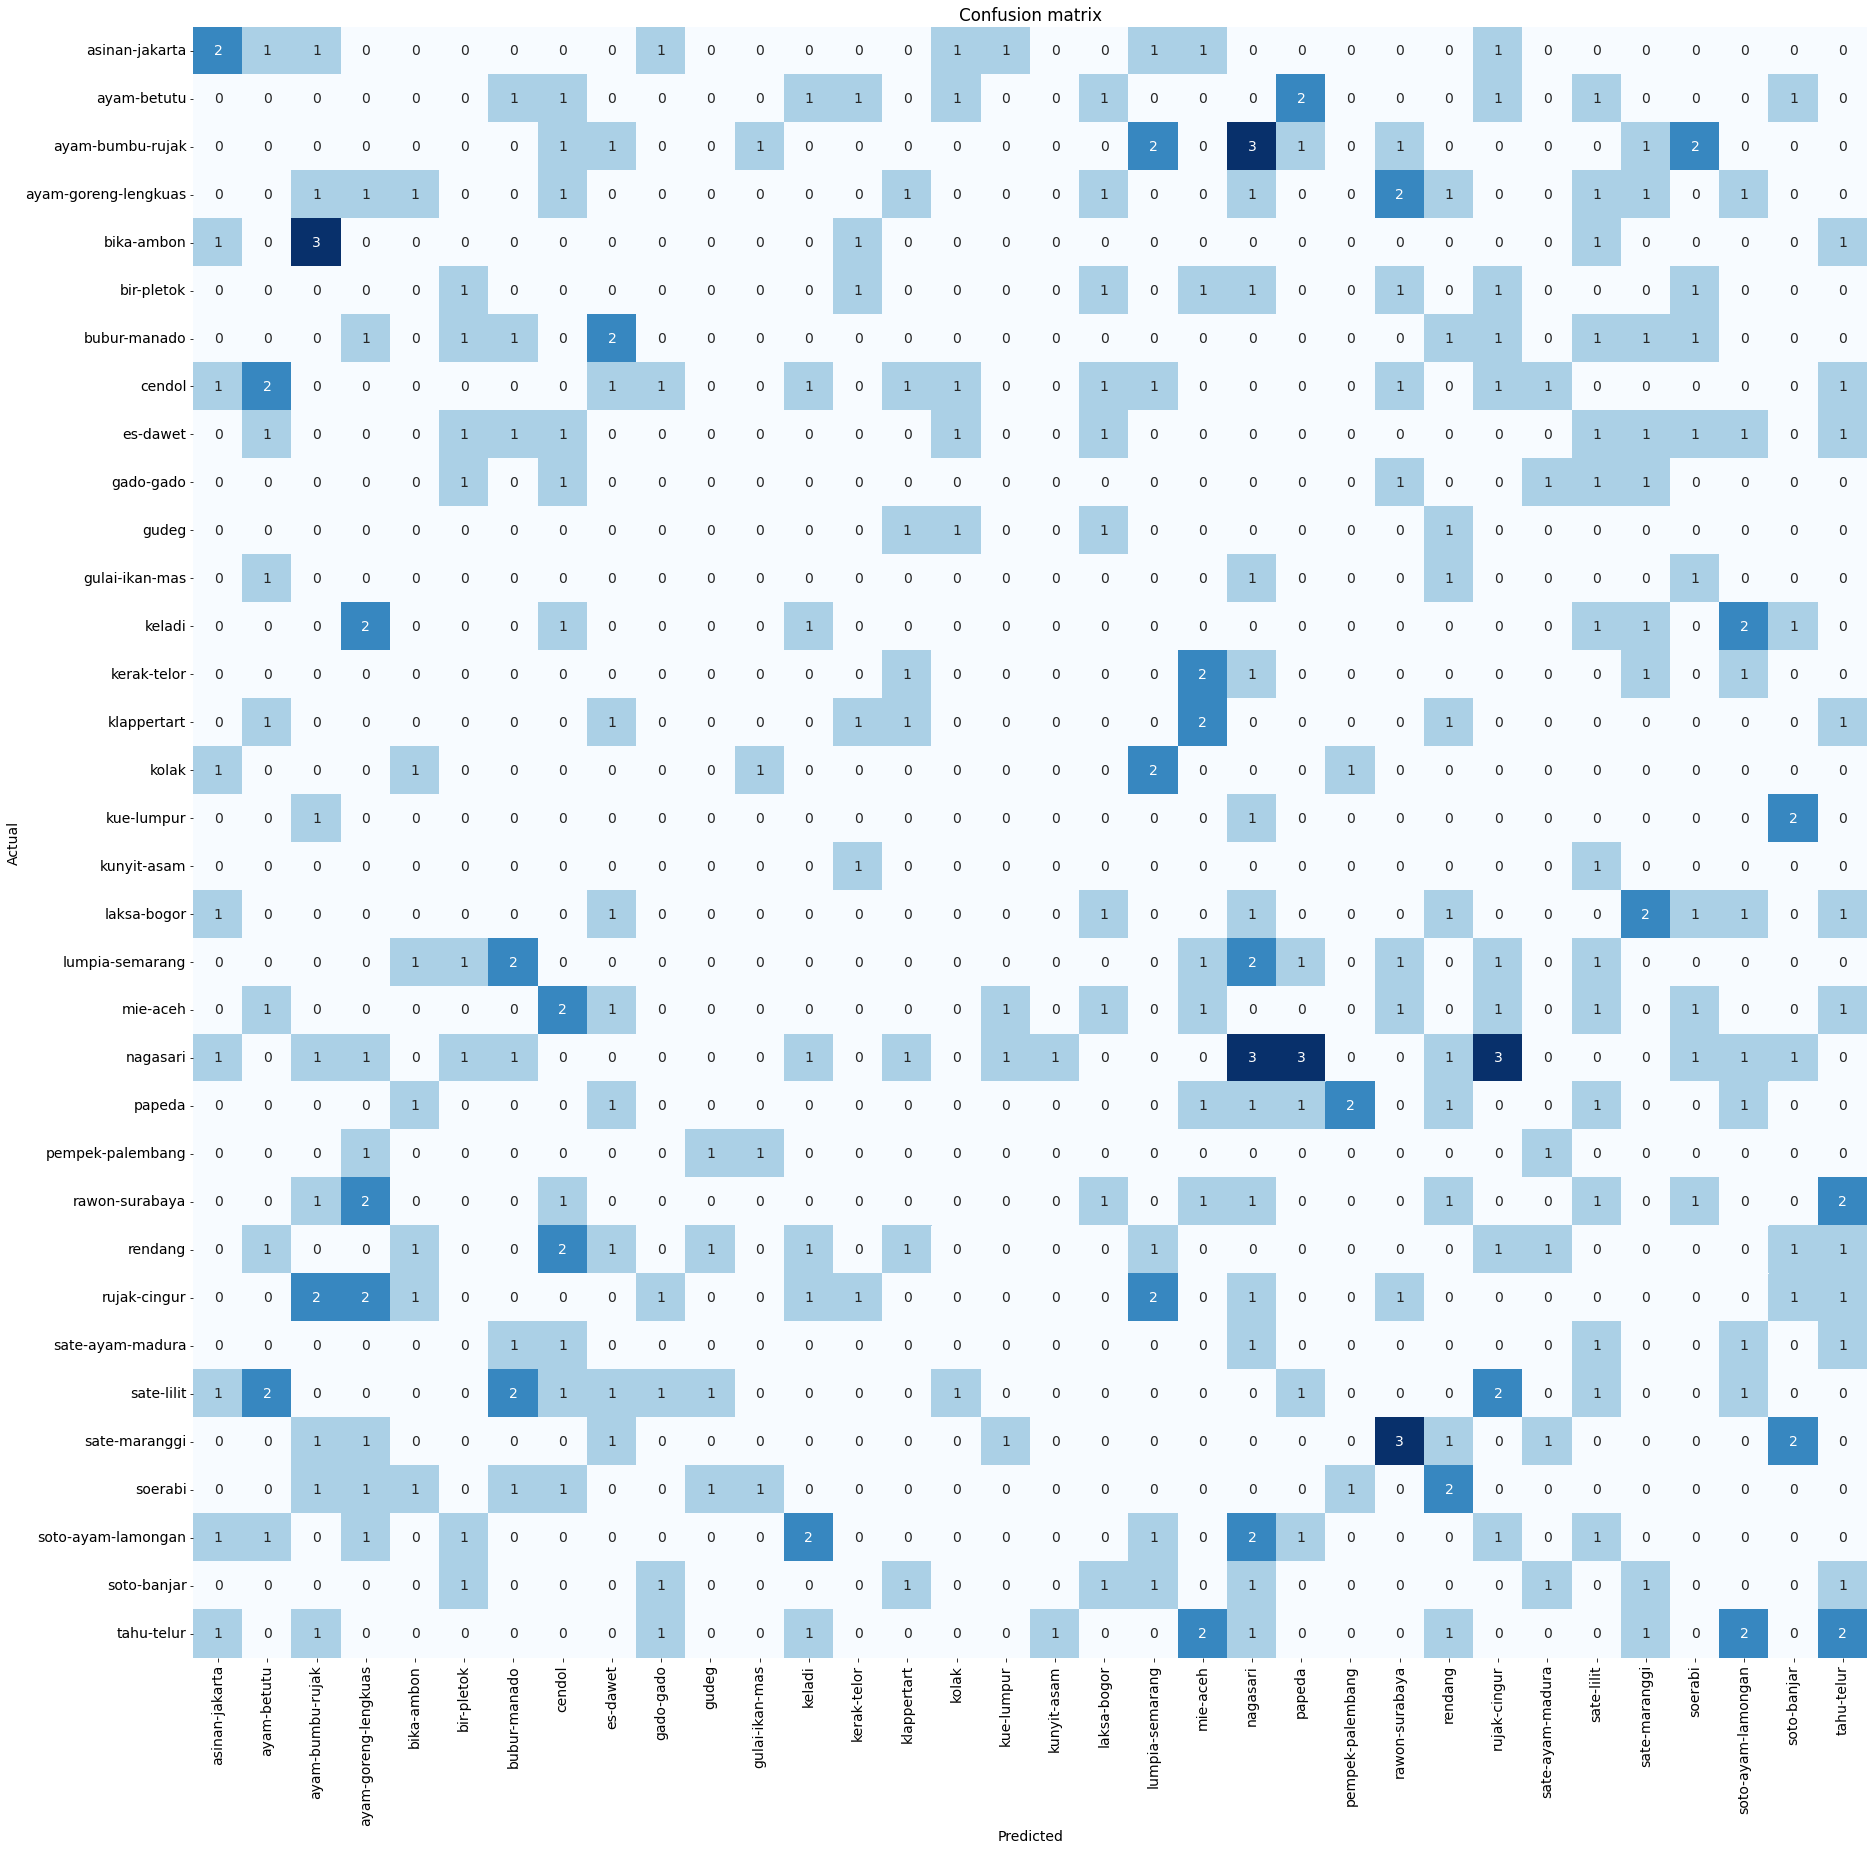

In [ ]:
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(34) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(34) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [ ]:
print('Classification report:\n---------------------\n', clr)

Classification report:
---------------------
               precision    recall  f1-score   support

           0       0.20      0.20      0.20        10
           1       0.00      0.00      0.00        11
           2       0.00      0.00      0.00        13
           3       0.08      0.08      0.08        13
           4       0.00      0.00      0.00         7
           5       0.12      0.12      0.12         8
           6       0.10      0.10      0.10        10
           7       0.00      0.00      0.00        14
           8       0.00      0.00      0.00        11
           9       0.00      0.00      0.00         6
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         4
          12       0.11      0.11      0.11         9
          13       0.00      0.00      0.00         6
          14       0.12      0.12      0.12         8
          15       0.00      0.00      0.00         6
          16       0.00      0.00  

## Export model

In [ ]:
model.save('foedtra_final_model.h5')

In [ ]:
model.save('/content/drive/MyDrive/Capstone Project - Foedtra/trained_model1/final_model/')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Capstone Project - Foedtra/trained_model1/final_model/assets


In [ ]:
MODEL_DIR = tempfile.gettempdir()
print(MODEL_DIR)

/tmp


In [ ]:
version = 1

export_path = os.path.join(MODEL_DIR, str(version))

if os.path.isdir(export_path):
    print('\nAlready saved a model, cleaning up\n')
    !rm -r {export_path}

model.save(export_path, save_format="tf")

print('\nexport_path = {}'.format(export_path))
!ls -l {export_path}

INFO:tensorflow:Assets written to: /tmp/1/assets

export_path = /tmp/1
total 15452
drwxr-xr-x 2 root root     4096 May 21 09:30 assets
-rw-r--r-- 1 root root  2467215 May 21 09:30 keras_metadata.pb
-rw-r--r-- 1 root root 13343248 May 21 09:30 saved_model.pb
drwxr-xr-x 2 root root     4096 May 21 09:30 variables


In [ ]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['inception_resnet_v2_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 224, 224, 3)
        name: serving_default_inception_resnet_v2_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_3'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 34)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict

Concrete Functions:
  Function Name: '__call__'
    Option #1
      Callable with:
        A

## Test tensorflow model server

In [ ]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [ ]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=foodrecognition \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 2 in a separate thread.


In [ ]:
!tail server.log

nohup: failed to run command 'tensorflow_model_server': No such file or directory
